# Step #1 Load the Data

In [2]:
# A tutorial for this file is available at www.relataly.com

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from ast import literal_eval


# in case you have placed the files outside of your working directory, you need to specify a path
path = 'data/movie_recommendations/' # for example: 'data/movie_recommendations/'  

# load the movie metadata
df_moviesmetadata=pd.read_csv(path + 'movies_metadata.csv', low_memory=False) 
print(df_moviesmetadata.shape)
print(df_moviesmetadata.columns)
df_moviesmetadata.head(1)

(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [3]:
# load the movie ratings
df_ratings=pd.read_csv(path + 'ratings_small.csv', low_memory=False) 

print(df_ratings.shape)
print(df_ratings.columns)
df_ratings.head(3)

(100004, 4)
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


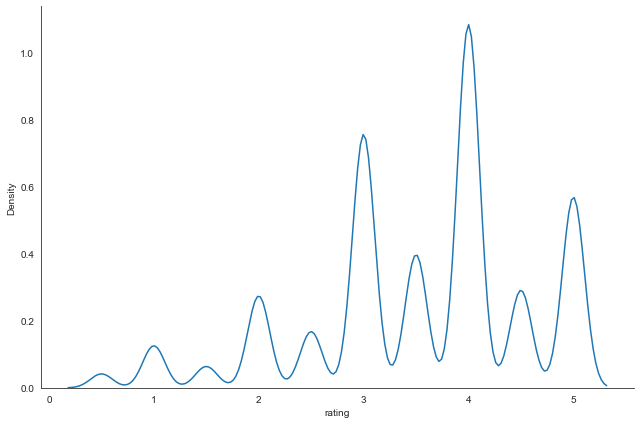

In [30]:
sns.displot(data=df_ratings, x='rating', kind='kde', aspect=1.5, height=6)

# Step #2 Preprocessing and Cleaning the Data

In [5]:
# 2.1 Movies Data

# remove invalid records with invalid ids
df_mmeta = df_moviesmetadata.drop([19730, 29503, 35587])

df_movies = pd.DataFrame()

# we only consider movies with at least 10 ratings
df_movies = df_mmeta[(df_mmeta['vote_count'] >= 10) & (df_mmeta['vote_average'].notnull())][['title','vote_count','vote_average']]

# extract the release year 
df_movies['year'] = pd.to_datetime(df_mmeta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# extract genres
df_movies['genres'] = df_mmeta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# change the index to movie_id
df_movies['movieId'] = pd.to_numeric(df_mmeta['id'])
df_movies = df_movies.set_index('movieId')

# add vote count
df_movies['vote_count'] = df_movies['vote_count'].astype('int')
df_movies

,title,vote_count,vote_average,year,genres
movieId,,,,,
862,Toy Story,5415,7.7,1995,"[Animation, Comedy, Family]"
8844,Jumanji,2413,6.9,1995,"[Adventure, Fantasy, Family]"
15602,Grumpier Old Men,92,6.5,1995,"[Romance, Comedy]"
31357,Waiting to Exhale,34,6.1,1995,"[Comedy, Drama, Romance]"
11862,Father of the Bride Part II,173,5.7,1995,[Comedy]
...,...,...,...,...,...
49279,The Man with the Rubber Head,29,7.6,1901,"[Comedy, Fantasy, Science Fiction]"
49271,The Devilish Tenant,12,6.7,1909,"[Fantasy, Comedy]"
49280,The One-Man Band,22,6.5,1900,"[Fantasy, Action, Thriller]"


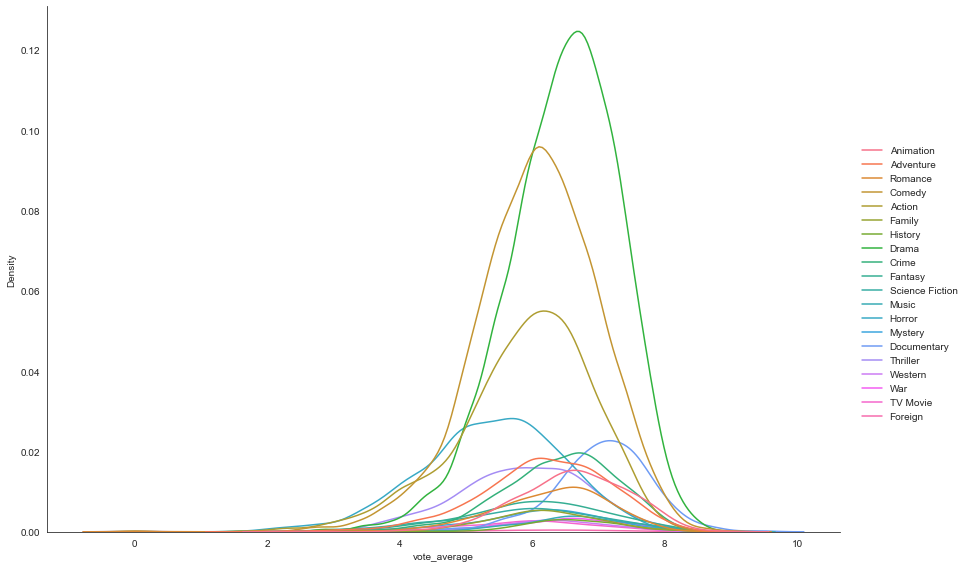

In [72]:
# Continue Exploring the Data
split_df = pd.DataFrame(df_movies['genres'].tolist())
df_merged = pd.concat([split_df.set_index(df_movies.index), df_movies], axis=1)
sns.displot(data=df_merged, x='vote_average', kind='kde', hue=0, aspect=1.5, height=8)

In [6]:
# 2.2 Ratings Data

# Drop na values
df_ratings_temp = df_ratings.dropna()

# Convert datetime
df_ratings_temp['timestamp'] =  pd. to_datetime(df_ratings_temp['timestamp'], unit='s')

print(f'unique users: {len(df_ratings_temp.userId.unique())}, ratings: {len(df_ratings_temp)}')
df_ratings_temp.head()

unique users: 671, ratings: 100004


,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


# Step #3 Split the Data in Train and Test

In [7]:
# The Reader class is used to parse a file containing ratings.
# The file is assumed to specify only one rating per line, such as in the df_ratings_temp file above.
reader = Reader()
ratings_by_users = Dataset.load_from_df(df_ratings_temp[['userId', 'movieId', 'rating']], reader)

# Split the Data into train and test
train_df, test_df = train_test_split(ratings_by_users, test_size=.2)

# Step #4 Train an SVD Model

In [8]:
# train an SVD model
svd_model = SVD()
svd_model_trained = svd_model.fit(train_df)

# Step #5 Evaluate Prediction Performance using Cross-Validation

<AxesSubplot:ylabel='Mean Absolute Error'>

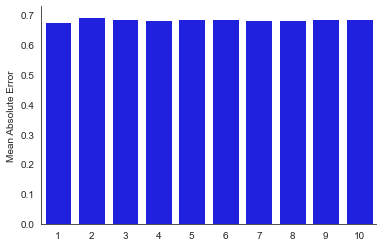

In [9]:
# 10-fold cross validation 
cross_val_results = cross_validate(svd_model_trained, ratings_by_users, measures=['RMSE', 'MAE', 'MSE'], cv=10, verbose=False)
test_mae = cross_val_results['test_mae']

# mean squared errors per fold
df_test_mae = pd.DataFrame(test_mae, columns=['Mean Absolute Error'])
df_test_mae.index = np.arange(1, len(df_test_mae) + 1)
df_test_mae.sort_values(by='Mean Absolute Error', ascending=False).head(15)

# plot an overview of the performance per fold
plt.figure(figsize=(6,4))
sns.barplot(y='Mean Absolute Error', x=df_test_mae.index, data=df_test_mae, color="b")
# plt.title('Mean Absolute Error')

# Step #6 Generate Predictions for UserId and MovieId

In [10]:
# predict ratings for the combination of user_id and movie_id
user_id = 217 # some test user from the ratings file
movie_id = 4002
rating_real = df_ratings.query(f'movieId == {movie_id} & userId == {user_id}')['rating'].values[0]
movie_title = df_movies[df_movies.index == 862]['title'].values[0]

print(f'Movie title: {movie_title}')
print(f'Actual rating: {rating_real}')

# predict and show the result
rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=True)

Movie title: Toy Story
Actual rating: 4.5
user: 217        item: 4002       r_ui = 4.50   est = 4.06   {'was_impossible': False}


In [11]:
# predict ratings for a single user_id and for all movies
user_id = 400 # some test user from the ratings file

# create the predictions
pred_series= []
df_ratings_filtered = df_ratings[df_ratings['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_movies.index, df_movies['title']):
    # check if the user has already rated a specific movie from the list
    rating_real = df_ratings.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    # generate the prediction
    rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    # add the prediction to the list of predictions
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

# print the results
df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 58


,movieId,title,predicted_rating,actual_rating
8880,1247,The Good Shepherd,4.592645,0.0
3194,318,The Million Dollar Hotel,4.572653,5.0
514,954,Mission: Impossible,4.530106,0.0
3361,1089,Point Break,4.487774,0.0
16409,4226,Shriek If You Know What I Did Last Friday the ...,4.447977,0.0
2671,593,Solaris,4.439145,3.0
6532,905,Pandora's Box,4.432316,0.0
2426,926,Galaxy Quest,4.426633,0.0
442,858,Sleepless in Seattle,4.415908,0.0
691,1939,Laura,4.398042,0.0
